In [3]:
#数据读取 为了方便大家更好的理解数据，我们重命名为中文
import numpy  as np
import pandas as pd
from   pandasql import sqldf
import os
data      = pd.read_csv("账户交易信息.csv", encoding="gbk")
train     = pd.read_csv("训练集标签.csv", encoding="gbk")
user_info = pd.read_csv("账户静态信息.csv", encoding="utf-8")
test      = pd.read_csv("test_dataset.csv", encoding="utf-8")
data = data.rename({
                    'jylsxh': '交易流水序号',
                    'zhdh': '账户代号',
                    'dfzh': '对方账号',
                    'jdbz': '借贷标志',
                    'jyje': '交易金额',
                    'jyye': '交易余额',
                    'dfhh': '对方行号',
                    'jyrq': '交易日期',
                    'jysj': '交易时间',
                    'jyqd': '交易渠道',
                    'zydh': '摘要代号',
                    'jdbj': '借贷标记',
                    'zhye': '账户余额',
                    'dfmccd': '对方名称长度'}, axis=1
                  )

train    = train.rename({'zhdh': '账户代号', 
                         'black_flag': '标签'}, axis=1
                       )

user_info =  user_info.rename({'zhdh': '账户代号',
                               'khrq':'开户日期', 
                               'xb': '性别', 
                             'khjgdh':'开户机构代号'}, axis=1
                              )

test    =  test.rename({'zhdh': '账户代号'},axis=1)

In [4]:
# 热门节点计算 -- 账户代号 - 对方账号
query = '''
select 
账户代号,
count(distinct 对方账号) as 对方账号_cnt
from  data 
group by 账户代号 
order by 对方账号_cnt desc 
limit 2000
'''
sqldf(query).head(5)

# 热门节点计算 -- 账户代号 - 对方账号
query = '''
select 
对方账号,
count(distinct 账户代号) as 账户代号_cnt
from  data
group by 对方账号
order by 账户代号_cnt desc 
limit 2000
'''
sqldf(query).head(5)

,对方账号,账户代号_cnt
0,0F76A363EACBDEAF,4407
1,14BEFED1370B730A,3804
2,EDE31EF0F69DC342,3758
3,DE7ABC0638690944,3250
4,1F77C9FDBDBE78D0,3201


In [5]:
### 数据聚合-剔除热门节点
query = '''
select 
a.账户代号,
a.对方账号,
账户代号_CNT
from
(select 
账户代号,
对方账号
from  data 
group by 账户代号,对方账号
) a
left join
(select 
对方账号,
count(distinct 账户代号) as 账户代号_CNT
from  data 
group by 对方账号 
having count(distinct 账户代号)>=500
) b
on a.对方账号 = b.对方账号
where b.对方账号 is null
'''
juhe_table = sqldf(query)
print(juhe_table.shape)
juhe_table.head()


(159557, 3)


,账户代号,对方账号,账户代号_CNT
0,00037295453A928A,1916F9D574C0979A,None
1,00037295453A928A,21EC552DC0DAEA16,None
2,00037295453A928A,2641BC24D6A3A88B,None
3,00037295453A928A,2D5FC4454465D9F3,None
4,00037295453A928A,328317D78D49C994,None


In [6]:
### 自我匹配 对数据进行构图 相似度计算
query = '''

select 账户代号_A,
       账户代号_B,
       AB交集_CNT,
       账户代号_A_CNT,
       账户代号_B_CNT,
       cast(AB交集_CNT as double) / (账户代号_A_CNT + 账户代号_B_CNT - AB交集_CNT) as sim
from (select 账户代号_A,
             账户代号_B,
             count(distinct 对方账号) as AB交集_CNT
      from (select a.账户代号 as 账户代号_A,
                   a.对方账号,
                   b.账户代号 as 账户代号_B
            from (select 账户代号,
                         对方账号
                  from juhe_table) a
                     join
                 (select 账户代号,
                         对方账号
                  from juhe_table) b
                 on a.对方账号 = b.对方账号
            where a.账户代号 <> b.账户代号) a
      group by 账户代号_A, 账户代号_B) a
         left join
     (select 账户代号,
             count(distinct 对方账号) as 账户代号_A_CNT
      from data
      group by 账户代号) b
     on a.账户代号_A = b.账户代号
         left join
     (select 账户代号,
             count(distinct 对方账号) as 账户代号_B_CNT
      from data
      group by 账户代号) c
     on a.账户代号_B = c.账户代号

'''
join_table =sqldf(query)
print(join_table.shape)
join_table.head()

(1975722, 6)


,账户代号_A,账户代号_B,AB交集_CNT,账户代号_A_CNT,账户代号_B_CNT,sim
0,00037295453A928A,000AA77144DC1BCC,1,25,45,0.014493
1,00037295453A928A,004304374B6A674B,2,25,29,0.038462
2,00037295453A928A,00AD928256643FB3,1,25,44,0.014706
3,00037295453A928A,00CAC587AF5B38D6,1,25,12,0.027778
4,00037295453A928A,011F8A1AAA852DEB,2,25,8,0.064516


In [9]:
import networkx as nx
import matplotlib.pyplot as plt

da = join_table[join_table['sim']>=0.0]

da = join_table[['账户代号_A','账户代号_B']].values
G  = nx.Graph()
for num in range(len(da)):
    G.add_edge(str(da[num,0]),str(da[num,1]))

####################################################################
#极大连通子图算法
print('极大连通子图算法开始...')
com = list(nx.connected_components(G))

#格式整理
df_com_connected  = pd.DataFrame()
for i in range(0, len(com)):
    d = pd.DataFrame({'Group_id': [i] * len(com[i]), '账户代号': list(com[i])})
    df_com_connected = pd.concat([df_com_connected,d])

####################################################################
#LPA 算法
print('LPA算法开始...')
from networkx.algorithms.community import asyn_lpa_communities as lpa
com = list(lpa(G))

#格式整理
df_com_lpa = pd.DataFrame()
for i in range(0,len(com)):
    d      = pd.DataFrame({'Group_id':[i]*len(com[i]),'账户代号':list(com[i])})
    df_com_lpa = pd.concat([df_com_lpa,d])

####################################################################
#Louvain算法
print('louvain图算法开始...')
from community import community_louvain
group = community_louvain.best_partition(G,resolution=2)

#格式整理
df_com_louvain = pd.DataFrame({'Group_id':group.values(),
                       '账户代号':group.keys()}
                    )
print('运行结束...')

极大连通子图算法开始...
LPA算法开始...
louvain图算法开始...
运行结束...


In [11]:
'''
团伙用户数统计 
df_com_connected
df_com_lpa
df_com_louvain
'''
df_com_louvain.groupby('Group_id').count().sort_values(by = '账户代号',ascending=False).head(5)


,账户代号
Group_id,
36,317
0,310
5,303
6,300
10,283


In [12]:
# 社群数据画像
'''
df_com_connected
df_com_lpa
df_com_louvain
'''

from   pandasql import sqldf

query = '''
select 
Group_id,
all_cnt,
test_cnt,
train_0_cnt,
train_1_cnt,
round(cast(train_1_cnt as double)/(train_0_cnt+train_1_cnt),4) as rate
from
(select
a.Group_id,
count(a.账户代号)                        as all_cnt,
sum(case when 标签=0 then 1 else 0 end) as train_0_cnt,
sum(case when 标签=1 then 1 else 0 end) as train_1_cnt,
sum(case when c.账户代号 is not null then 1 else 0 end) as test_cnt
from
(select
Group_id,
账户代号
from df_com_louvain
) a
left join
(select
账户代号,
标签
from train
) b
on a.账户代号 = b.账户代号
left join
(select 
账户代号
from test
) c
on a.账户代号 = c.账户代号
group by group_id
) a
order by train_1_cnt desc
limit 2000
'''

sqldf(query).head(20)

,Group_id,all_cnt,test_cnt,train_0_cnt,train_1_cnt,rate
0,5,303,236,17,50,0.7463
1,42,211,162,28,21,0.4286
2,1,238,188,31,19,0.3800
3,0,310,248,49,13,0.2097
4,16,222,171,40,11,0.2157
5,10,283,227,46,10,0.1786
6,13,114,95,9,10,0.5263
7,8,141,112,21,8,0.2759
8,4,250,197,46,7,0.1321
9,11,164,129,28,7,0.2000


In [12]:
# 分群结果概览

'''
团伙用户数统计
df_com_connected
df_com_lpa
df_com_louvain
'''

df_com_louvain.groupby('Group_id').count().sort_values(by = '账户代号',ascending=False).head(12)


,账户代号
Group_id,
2,33453
4,23266
0,22514
3,12208
6,11933
1,4014
11,3810
14,3597
8,3301


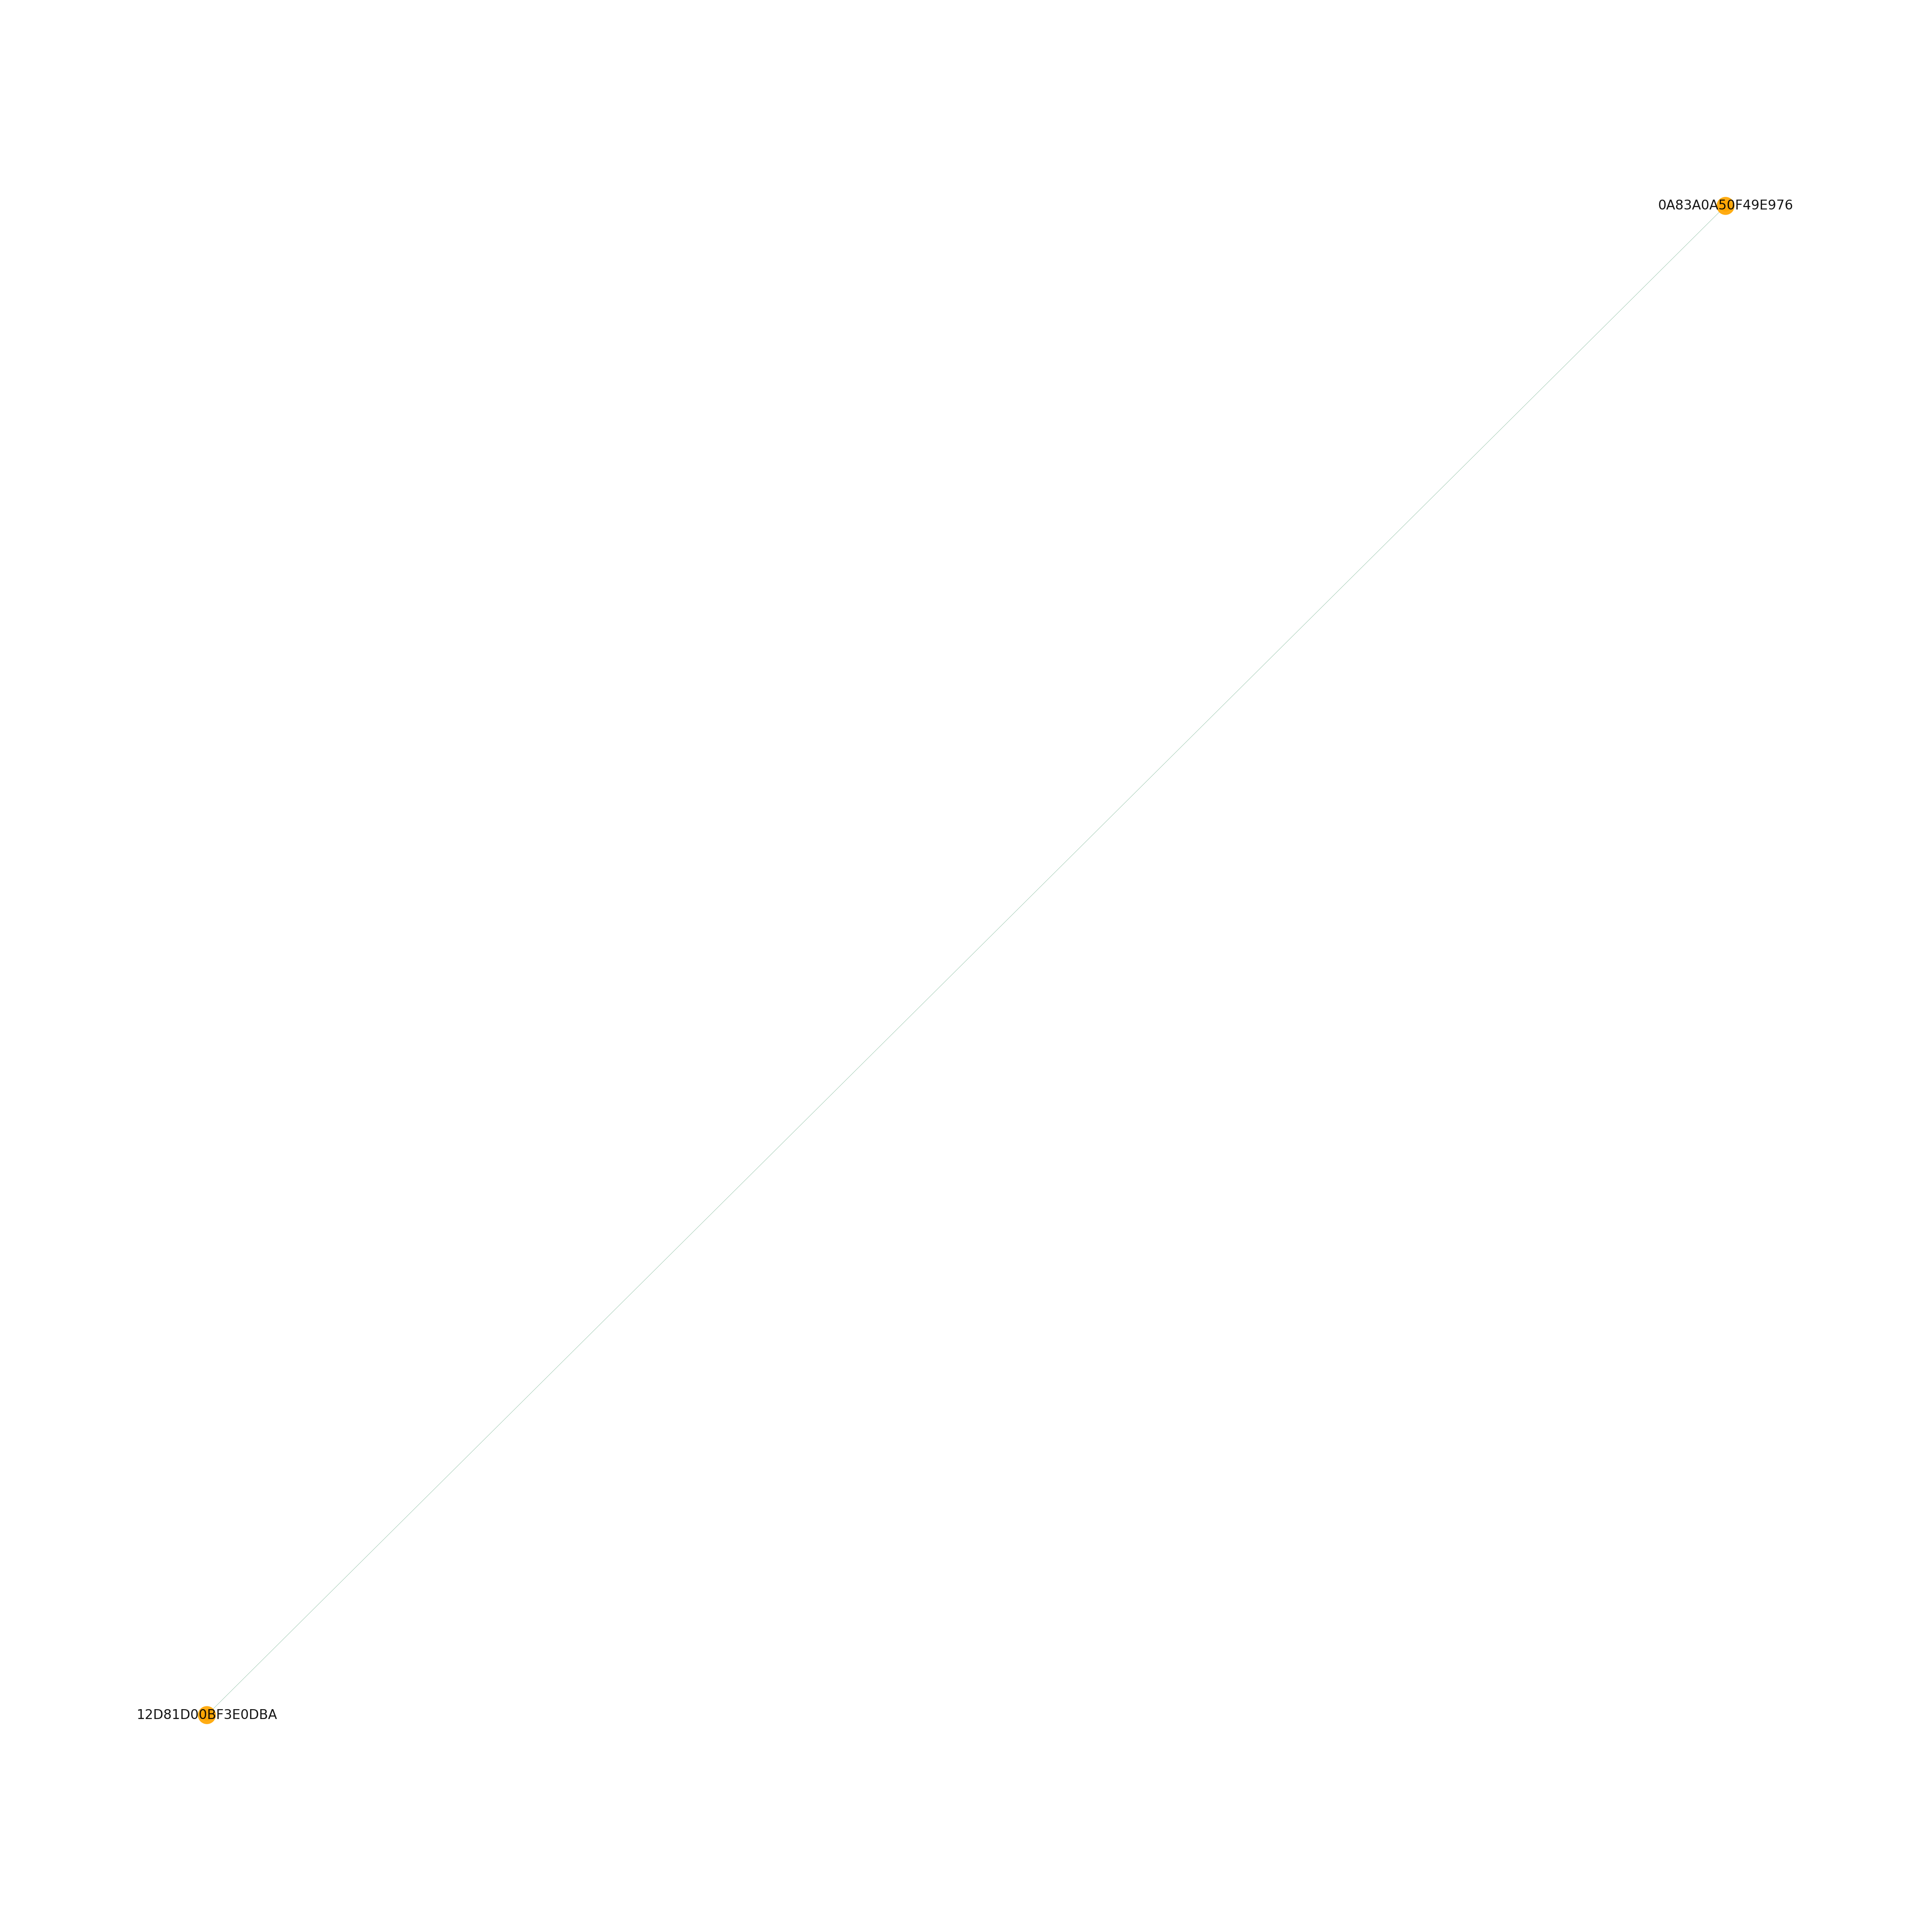

In [13]:
# 交替看看三个算法的情况
'''
df_com_connected
df_com_lpa
df_com_louvain
'''

query = '''
select 
a.账户代号_A,
a.账户代号_B
from
(select 
账户代号_A,
账户代号_B
from join_table
)a

left join
(select
group_id,
账户代号
from df_com_louvain  --替换算法查看
where group_id=39
) b 
on a.账户代号_A = b.账户代号

left join
(select
group_id,
账户代号
from df_com_louvain --替换算法查看
where group_id=39
) c 
on a.账户代号_B = c.账户代号
where b.账户代号 is not null and c.账户代号 is not null
'''
dg = sqldf(query)
df_u_g = pd.DataFrame(pd.concat([dg['账户代号_A'],dg['账户代号_B']]))
df_u_g.columns = ['账户代号']


#节点来源处理
query = '''
select 
a.账户代号,
case when b.账户代号 is not null and 标签=1 then 'is_black_1' 
     when b.账户代号 is not null and 标签=0 then 'is_black_0' 
     when c.账户代号 is not null then 'is_test' else 'is_other' end  as flag
from
(select
账户代号
from df_u_g
group by 账户代号
) a
left join
(select
账户代号,
标签
from train
) b
on a.账户代号 = b.账户代号
left join
(select 
账户代号
from test
) c
on a.账户代号 = c.账户代号
'''

flag = sqldf(query)


# 社区还原并可视化
da = dg[['账户代号_A','账户代号_B']].values
G  = nx.Graph()
for num in range(len(da)):
    G.add_edge(str(da[num,0]),str(da[num,1]))

#显示图片
plt.figure(figsize=(5,5),dpi=1200)


# 颜色设置
'''
训练集-黑样本  -- 红色 r
训练集-白羊本  -- 黑色 black
测试集 --------- 橘色 Orange
对手账户-------- 灰色
'''
colors_dic={'is_black_1':'r','is_black_0':'black','is_test':'Orange','is_other':'#9AC0CD'}
#colors_dic={'is_black_1':'r','is_black_0':'black','is_test':'#9AC0CD','is_other':'#9AC0CD'}

colors = flag['flag'].map(colors_dic).tolist()

#节点大小设置，与度关联
node_size = [G.degree(i)**0.75*3 for i in G.nodes()]


#kamada_kawai_layout spring_layout

nx.draw_networkx(G,
                 pos = nx.kamada_kawai_layout(G),
                 node_color = colors,
                 edge_color = '#2E8B57',
                 #with_labels=False,
                 font_size = 2,
                 node_size = node_size,
                 alpha = 0.92,
                 width = 0.03
                 )
plt.axis('off')
plt.show()